In [1]:
library(readr)
library(dplyr)
library(tidyr)
library(stringr)
library(lfe)
library(ggsci)
library(lubridate)
library(ggplot2)
library(doMC)
library(gridExtra)
library(ggpubr)
library(stargazer)
library(scales)
registerDoMC(4)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘lubridate’


The following objects are masked from ‘package:dplyr’:

    intersect, setdiff, union


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



Attaching package: ‘scales’


The follo

In [24]:
fp <- '/pool001/mfzhao/'
df <- read_rds(str_c(fp, '/PROCESSED_DATA/panel_pre_xgr.RDS'))

In [25]:
df %>%
    select(key,
           date, 
           cluster,
           n,
           log_mcbgv,
           log_pnchd,
           log_pgt1hafh, 
           log_ppthlt75,
           log_pgt2kmt,
           matches('new'),
           matches('unemp'),
           matches('^log_stalter_'), 
           matches('^[pt][rm][ca][px][01][0-9]$'),
           matches('^p[123]...$'),
           matches('stalter_p[123]...$'),
           matches('stalter[NF]'),
           matches('stalter_[pt][rm][ca][px][01][0-9]$'),
           matches('as_(st)?new')) -> df

In [26]:
cns <- colnames(df)
cns

[1] "key"                  "date"                 "cluster"             
 [4] "n"                    "log_mcbgv"            "log_pnchd"           
 [7] "log_pgt1hafh"         "log_ppthlt75"         "log_pgt2kmt"         
[10] "newcases"             "newdeaths"            "stnewcases"          
[13] "stnewdeaths"          "as_newcases"          "as_newdeaths"        
[16] "as_stnewcases"        "as_stnewdeaths"       "ct_unemp_rate"       
[19] "st_unemp_rate"        "log_stalter_mcbgv"    "log_stalter_pnchd"   
[22] "log_stalter_pgt1hafh" "log_stalter_ppthlt75" "log_stalter_pgt2kmt" 
[25] "prcp01"               "prcp02"               "prcp03"              
[28] "prcp04"               "prcp05"               "prcp06"              
[31] "prcp07"               "prcp08"               "prcp09"              
[34] "prcp10"               "tmax02"               "tmax03"              
[37] "tmax04"               "tmax05"               "tmax06"              
[40] "tmax07"               "tmax08"               "tmax09"              
[43] "tmax10"               "p1sdp"                "p2shp"               
[46] "p3rop"                "stalter_p1sdp"        "stalter_p2shp"       
[49] "stalter_p3rop"        "stalterNear_p1sdp"    "stalterNear_p2shp"   
[52] "stalterNear_p3rop"    "stalterFar_p1sdp"     "stalterFar_p2shp"    
[55] "stalterFar_p3rop"     "stalter_prcp01"       "stalter_prcp02"      
[58] "stalter_prcp03"       "stalter_prcp04"       "stalter_prcp05"      
[61] "stalter_prcp06"       "stalter_prcp07"       "stalter_prcp08"      
[64] "stalter_prcp09"       "stalter_prcp10"       "stalter_tmax02"      
[67] "stalter_tmax03"       "stalter_tmax04"       "stalter_tmax05"      
[70] "stalter_tmax06"       "stalter_tmax07"       "stalter_tmax08"      
[73] "stalter_tmax09"       "stalter_tmax10"

In [27]:
ldvs <- c('log_mcbgv', 'log_pgt2kmt', 'log_pgt1hafh', 'log_pnchd')
dvs  <- c('mcbgv', 'pnchd', 'pgt1hafh', 'pgt2kmt')

In [29]:
fips  <- read_csv('/pool001/mfzhao/geo_data/county_fips_master.csv')
oxpol <- read_csv('/pool001/mfzhao/policy/OxCGRT_US_subnational_05Aug2020.csv',
                  col_types = cols(E4_Notes = col_character()))
WM    <- read_rds(str_c(fp, 'PROCESSED_DATA/stateWM.RDS'))

Parsed with column specification:
cols(
  fips = col_double(),
  county_name = col_character(),
  state_abbr = col_character(),
  state_name = col_character(),
  long_name = col_character(),
  sumlev = col_double(),
  region = col_double(),
  division = col_double(),
  state = col_double(),
  county = col_double(),
  crosswalk = col_character(),
  region_name = col_character(),
  division_name = col_character()
)



In [30]:
oxpol %>%
    filter(CountryCode == 'USA') -> oxpol

oxpol %>%
  filter(`C7_Restrictions on internal movement` > 0,
         Jurisdiction == 'STATE_ALL') %>%
  group_by(RegionCode) %>%
  filter(row_number() == 1) %>%
  select(RegionCode, c7 = Date) -> c7

oxpol %>%
  filter(`C6_Stay at home requirements` > 0,
         Jurisdiction == 'STATE_ALL') %>%
  group_by(RegionCode) %>%
  filter(row_number() == 1) %>%
  select(RegionCode, c6 = Date) -> c6

In [31]:
c7 %>%
    full_join(c6) %>%
    rowwise() %>%
    mutate(p2alt = min(c6, c7, na.rm = T), 
           p2alt = ymd(p2alt),
           state_abbr = str_replace(RegionCode, 'US_', '')) %>%
    select(state_abbr, p2alt) %>%
    left_join(fips) %>%
    select(key = fips, p2alt) %>%
    mutate(key = str_pad(key, 5, pad = '0')) %>%
    distinct() -> temp

Joining, by = "RegionCode"

Joining, by = "state_abbr"



In [32]:
weightedAlters <- function(df, wm, ...) {
    df %>% 
        select(date, key, ...) %>%
        spread(key = key, value = ...) %>%
        ungroup() %>%
        select(-date) %>%
        as.matrix() -> txn_data
    
    df %>%
        ungroup() %>%
        select(date) %>%
        distinct() %>%
        arrange(date) -> dates
    
    outMatrix <- tcrossprod(txn_data, wm)
    colnames(outMatrix) <- colnames(txn_data)
    
    data.frame(dates, outMatrix) %>%
        gather(key = 'key', value = 'value', -date) %>%
        arrange(date, key) %>%
        select(-date, -key) -> out_df
    return(out_df$value)
}

In [36]:
df %>%
    left_join(temp) %>%
    group_by(key) %>%
    fill(p2alt, .direction = "updown") %>%
    mutate(p2alt = ifelse(date < p2alt, 0, 1)) %>%
    replace_na(list(p2alt = 0)) %>%
    ungroup() %>%
    mutate(stalter_p2alt          = weightedAlters(., WM, p2alt),
           stalter_newcases       = weightedAlters(., WM, newcases),
           stalter_newdeaths      = weightedAlters(., WM, newdeaths),
           stalter_stnewcases     = weightedAlters(., WM, stnewcases),
           stalter_stnewdeaths    = weightedAlters(., WM, stnewdeaths),
           stalter_ct_unemp_rate  = weightedAlters(., WM, ct_unemp_rate),
           stalter_st_unemp_rate  = weightedAlters(., WM, st_unemp_rate),
           as_stalter_newcases    = asinh(stalter_newcases), 
           as_stalter_newdeaths   = asinh(stalter_newdeaths),
           as_stalter_stnewcases  = asinh(stalter_stnewcases),
           as_stalter_stnewdeaths = asinh(stalter_stnewdeaths)) -> df

Joining, by = "key"



In [71]:
get_coefs <- function(dv, vars, ivmod = F, ...) {
    lhs <- str_c(dv, ' ~ ')
    rhs <- str_c(vars, '| key + date | ')

    if(ivmod == T) {
        alter_weather <- str_c(cns[str_detect(cns, '^stalter_[pt][rm][ca][px][01][0-9]$')], collapse = ' + ')
        iv <- ifelse(str_detect(dv, 'log'), str_replace(dv, 'log', 'log_stalter'), str_c('alter_', dv))
        ivf <- str_c('(', iv, ' ~ ', alter_weather, ') | cluster')
        rhs <- str_c(rhs, ivf)
    } else {
        rhs <- str_c(rhs, '0 | cluster')
    }
    form  <- as.formula(str_c(lhs, rhs))
    model <- felm(form, df, weights = df$n, ...)
    
    as.data.frame(summary(model)$coef) %>%
        mutate(var   = rownames(.),
               dv    = dv,
               model = ifelse(vars == f1, 'base',
                              ifelse(vars == f2, 'base spillovers',
                                     ifelse(vars == f3, 'p2alt policy',
                                            ifelse(vars == f4, 'p2alt spillovers', 'stalter controls'))))) %>%
        filter(!str_detect(var, '[pPtT][rRmM][cCaA][pPxX]')) %>%
        select(7, 6, 5, 1, 2, 3, 4) -> out
    
    colnames(out) <- c('model', 'dv', 'var', 'estimate', 'se', 't', 'p-val')
    return(out)
}

In [72]:
ctrls <- '+ prcp01 + prcp02 + prcp03 + prcp04 + prcp05 + prcp06 + prcp07 + prcp08 + prcp09 + prcp10 + 
            tmax02 + tmax03 + tmax04 + tmax05 + tmax06 + tmax07 + tmax08 + tmax09 + tmax10 + 
            as_newcases + as_newdeaths + as_stnewcases + as_stnewdeaths + ct_unemp_rate + st_unemp_rate '
ctrls2 <- '+ as_stalter_newcases + as_stalter_newdeaths + as_stalter_stnewcases + as_stalter_stnewdeaths + 
             stalter_ct_unemp_rate + stalter_st_unemp_rate'

f1    <- str_c(' p1sdp + p2shp + p3rop ', ctrls)  
f2    <- str_c(' p1sdp + p2shp + p3rop + stalter_p1sdp + stalter_p2shp + stalter_p3rop ', ctrls)
f3    <- str_c(' p1sdp + p2alt + p3rop ', ctrls)  
f4    <- str_c(' p1sdp + p2alt + p3rop + stalter_p1sdp + stalter_p2alt + stalter_p3rop ', ctrls)
f5    <- str_c(' p1sdp + p2shp + p3rop + stalter_p1sdp + stalter_p2shp + stalter_p3rop ', ctrls, ctrls2)

In [73]:
foreach(dv = ldvs, .combine = rbind) %:% 
    foreach(f = c(f1, f2, f3, f4, f5), .combine = rbind) %dopar%
    get_coefs(dv, f, F) -> coefs

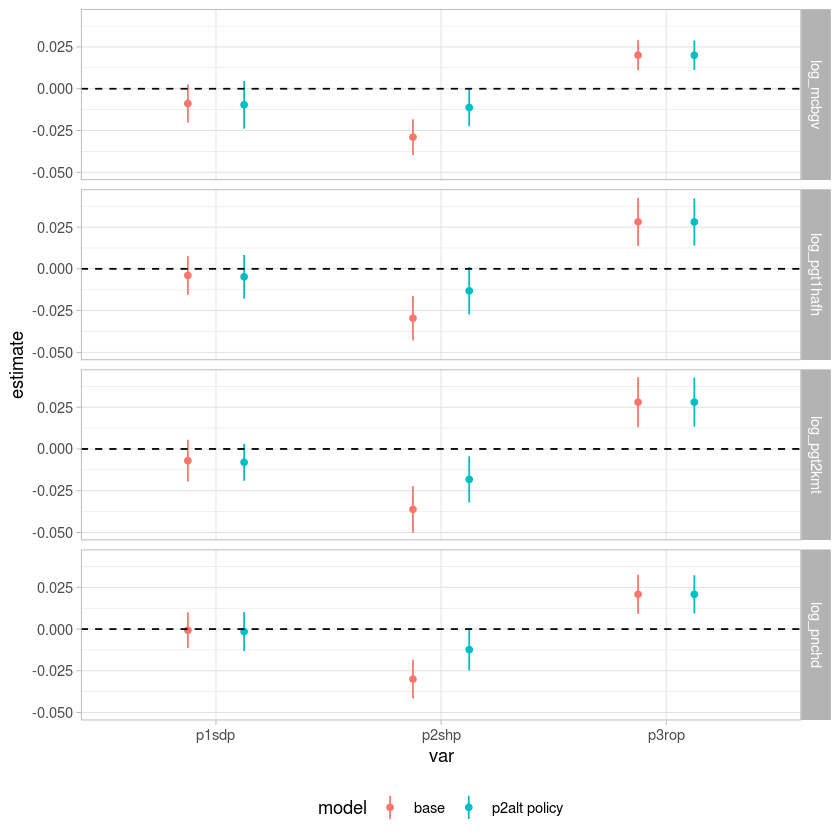

In [70]:
coefs %>%
    filter(model == 'base' | model == 'p2alt policy') %>%
    filter(str_detect(var, 'p[123]')) %>%
    mutate(var = str_replace(var, 'p2alt', 'p2shp')) %>%
    ggplot(aes(x = var, y = estimate, color = model)) + 
    geom_point(position = position_dodge(width = 0.5)) + 
    geom_linerange(aes(ymin = estimate - 1.98 * se,
                       ymax = estimate + 1.98 * se),
                   position = position_dodge(width = 0.5)) +
    facet_grid(dv ~ .) +
    geom_hline(aes(yintercept = 0), linetype = 2) +
    theme_light() + 
    theme(legend.position = 'bottom')

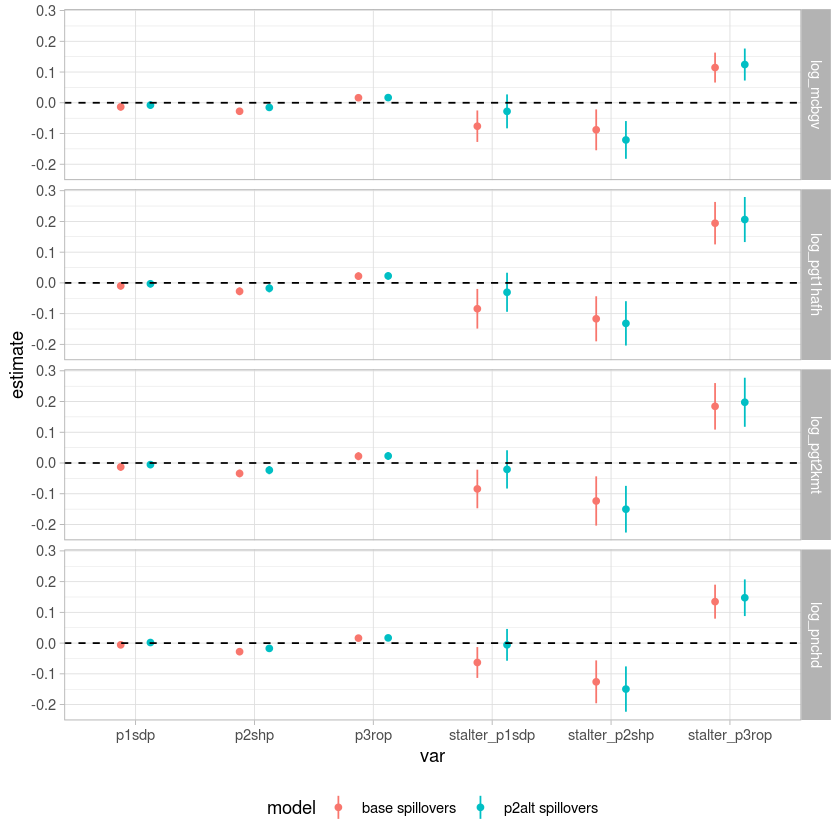

In [68]:
coefs %>%
    filter(str_detect(model, 'spillovers')) %>%
    filter(str_detect(var, 'p[123]')) %>%
    mutate(var = str_replace(var, 'p2alt', 'p2shp')) %>%
    ggplot(aes(x = var, y = estimate, color = model)) + 
    geom_point(position = position_dodge(width = 0.5)) + 
    geom_linerange(aes(ymin = estimate - 1.98 * se,
                       ymax = estimate + 1.98 * se),
                   position = position_dodge(width = 0.5)) +
    facet_grid(dv ~ .) +
    geom_hline(aes(yintercept = 0), linetype = 2) +
    theme_light() + 
    theme(legend.position = 'bottom')

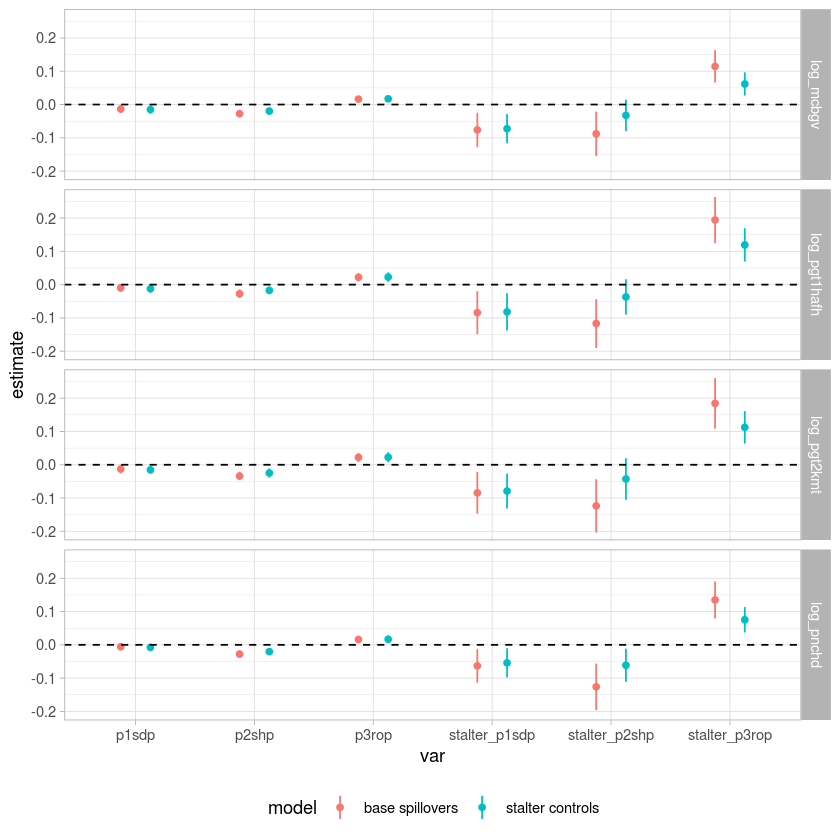

In [75]:
coefs %>%
    filter(str_detect(var, 'p[123]')) %>%
    filter(model == 'base spillovers' | model == 'stalter controls') %>%
    ggplot(aes(x = var, y = estimate, color = model)) + 
    geom_point(position = position_dodge(width = 0.5)) + 
    geom_linerange(aes(ymin = estimate - 1.98 * se,
                       ymax = estimate + 1.98 * se),
                   position = position_dodge(width = 0.5)) +
    geom_hline(aes(yintercept = 0), linetype = 2) +
    facet_grid(dv ~ .) +
    theme_light() + 
    theme(legend.position = 'bottom')

In [ ]:
write_csv(coefs, str_c(fp, 'RESULTS/'))

In [ ]:
options(repr.plot.width=15, repr.plot.height=10)
pn <- c('p1sdp' = "Initial Policies",
        'p2shp' = "Shelter-in-place",
        'p3rop' = "Reopening",
        'a'     = 'Ego state policy',
        'b'     = 'Alter state policy')

coefs %>%
    mutate(dv  = str_replace(dv, '\\.r', ''),
           var = str_replace(var, '\\.r', ''),
           var = ifelse(str_detect(var, 'fit'), 'Peer Effect', var)) %>%
    filter(!str_detect(var, 'unemp')) %>%
    filter(!str_detect(var, 'new')) %>%
    filter(var != 'Peer Effect') %>%
    filter(!str_detect(model, 'iv')) %>%
    filter(!str_detect(model, 'apnf')) %>%
    mutate(vtype = ifelse(str_detect(var, 'stalter'), 'b', 'a'),
           var   = str_replace(var, 'stalter_', ''),
           model = factor(model, levels = c('base', 'base + iv', 'ap', 'ap + iv')),
           dv = case_when(dv == 'log_mcbgv' ~ 'Average number of locations visited',
                         dv == 'log_pgt2kmt' ~ 'Traveling more than 2km',
                         dv == 'log_pgt1hafh' ~ 'More than 1 hour away from home',
                         TRUE ~ 'Leaving home'),
           dv = factor(dv, levels = c('Average number of locations visited', 
                                      'Traveling more than 2km', 
                                      'More than 1 hour away from home', 
                                      'Leaving home')),
           estimate = exp(estimate) - 1,
           u95ci   = exp(estimate + 1.98 * se) - 1,
           l95ci    = exp(estimate - 1.98 * se) - 1,
           model = ifelse(model == 'base', 'DiD without\nspillovers', 'DiD with\nalter state policies'),
           model = factor(model, levels = c('DiD without\nspillovers',
                                           'DiD with\nalter state policies'))) %>%
    ggplot(aes(x = model, y = estimate, color = dv)) +
    geom_hline(aes(yintercept = 0), linetype = 2) +
    geom_point(position = position_dodge(width = .5), size = 2) + 
    geom_linerange(aes(ymin = estimate - 1.98 * se, ymax = estimate + 1.98 * se), 
                   position = position_dodge(width = .5), size = .5) +
    facet_grid(vtype~var, scales = 'free_y', labeller = as_labeller(pn)) +
    xlab('') + 
    ylab('Relative effect size') +
    scale_color_d3() +
    labs(color = "Outcome") +
    theme_light() +
    theme(text = element_text(size=20),
          legend.position = 'bottom',
          legend.title = element_blank()) + 
    scale_y_continuous(labels=percent) + 
    guides(color = guide_legend(nrow = 2)) -> p2a

#ggsave('/home/dholtz/p4_new.pdf', p2a, device = 'pdf', width = 6.5, height = 5, scale = 2)
p2a

In [ ]:
# stalter Near Far Plot
options(repr.plot.width=15, repr.plot.height=10)
pn <- c('log_mcbgv'    = 'Average number of\nlocations visited',
        'log_pgt2kmt'  = 'Traveling more\nthan 2km',
        'log_pgt1hafh' = 'More than 1 hour\naway from home',
        'log_pnchd'    = 'Leaving home')

coefs %>%
    mutate(dv  = str_replace(dv, '\\.r', ''),
           var = str_replace(var, '\\.r', ''),
           var = ifelse(str_detect(var, 'fit'), 'Peer Effect', var)) %>%
    filter(!str_detect(var, 'new')) %>%
    filter(model == 'apnf' | model == 'ap') %>%
    filter(str_detect(var, 'stalter')) %>%
    mutate(nf  = ifelse(str_detect(var, 'Near'), 'Near',
                       ifelse(str_detect(var, 'Far'), 'Far', 'Combined')),
           nf  = factor(nf, levels = c('Combined', 'Near', 'Far')),
           var = str_replace(var, 'stalterNear_', ''),
           var = str_replace(var, 'stalterFar_', ''),
           var = str_replace(var, 'stalter_', '')) %>%
    ggplot(aes(x = var, y = estimate, color = nf)) +
    geom_hline(aes(yintercept = 0), linetype = 2) +
    geom_point(position = position_dodge(0.25)) + 
    geom_linerange(aes(ymin = estimate - 1.98 * se, ymax = estimate + 1.98 * se), position = position_dodge(0.25)) + 
    facet_grid(dv ~ ., scales = 'free', labeller = as_labeller(pn)) + 
    xlab('') + 
    scale_x_discrete(labels = c('Alter Initial Policies', 'Alter Shelter-in-Place', 'Alter Reopening')) + 
    ylab('Estimate') +
    scale_color_d3() +
    labs(color = "Outcome") +
    theme_light() +
    theme(text = element_text(size=20),
          legend.position = 'bottom',
          legend.title = element_blank()) -> si_did_stnf

ggsave('~/SI_plots/si_did_stnf.pdf', si_did_stnf, device = 'pdf', width = 6.5, height = 5, scale = 2)
si_did_stnf

In [ ]:
get_models <- function(dv, vars, ivmod = F, ...) {
    lhs <- str_c(dv, ' ~ ')
    rhs <- str_c(vars, '| key + date | ')

    if(ivmod == T) {
        alter_weather <- str_c(cns[str_detect(cns, '^stalter_[pt][rm][ca][px][01][0-9]$')], collapse = ' + ')
        iv <- ifelse(str_detect(dv, 'log'), str_replace(dv, 'log', 'log_stalter'), str_c('alter_', dv))
        ivf <- str_c('(', iv, ' ~ ', alter_weather, ') | cluster')
        rhs <- str_c(rhs, ivf)
    } else {
        rhs <- str_c(rhs, '0 | cluster')
    }
    form  <- as.formula(str_c(lhs, rhs))
    model <- felm(form, df, weights = df$n, ...)
    
    return(model)
}

In [ ]:
foreach(dv = ldvs) %dopar% get_models(dv, f1, F) -> models_base

In [ ]:
stargazer(models_base)

In [ ]:
foreach(dv = ldvs) %dopar% get_models(dv, f2, F) -> models_ap

In [ ]:
stargazer(models_ap)

In [ ]:
foreach(dv = ldvs) %dopar% get_models(dv, f3, F) -> models_apnf

In [ ]:
stargazer(models_apnf, 
                  keep=c('p1sdp', 'p2shp', 'p3rop', 
                         'stalterNear_p1sdp', 'stalterNear_ps2hp', 'stalterNear_p3rop',
                         'stalterFar_p1sdp', 'stalterFar_ps2hp', 'stalterFar_p3rop'),
                  covariate.labels = c('Ego State Initial Policies',
                                       'Ego State Shelter-in-Place',
                                       'Ego State Reopening',
                                       'Alter Nearby Initial Policies',
                                       'Alter Nearby Shelter-in-place',
                                       'Alter Nearby Reopenings',
                                       'Alter Distant Initial Policies',
                                       'Alter Distant Shelter-in-place',
                                       'Alter Distant Reopenings'),
                  dep.var.labels = c('log(Number of locations visited)',
                                     'log(Percent traveling more than 2 km)',
                                     'log(Percent more than 1 hour away from home)',
                                     'log(Percent leaving home)'),
                  label='tab:apnf',
                  title='Alters\' Policies Near/Far Model Results',
                  omit.stat=c("f", "ser"),
                  notes = 'State-Clustered Standard Errors are reported.',
          notes.append=TRUE,
          font.size='tiny')